# Demonstration of basic BSREM implementation with SIRF

`BSREM1` and `BSREM2` are 2 different implementations of a (modified) BSREM algorithm. `BSREM1` uses the `sirf.STIR` objective function to compute gradients etc, while `BSREM2` computes these in terms of the `sirf.STIR.AcquisitionModel`. The actual algorithm is implemented in the base class `BSREMSkeleton`. Note that the implementations are in terms of "lists of subset-data" and corresponding "list of acquisition models" etc. (This is more efficient than using the subset functionality in the `sirf.STIR` acquisition models/objective function.)

The source code for these implementations can be found in `src/Python`, or you could run `BSREM1??`

This notebook is illustrates these algorithms with two datasets:
- a simple 2D simulation (largely based on the `display_and_projection` notebook from the SIRF-Exercises)
- the mMR NEMA IQ data (downloadable via the SIRF-exercises as well)

Author: Kris Thielemans  

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.  
Copyright 2015 - 2018, 2021, 2024 University College London.

This is software developed for the Collaborative Computational
Project in Synergistic Reconstruction for Biomedical Imaging
(http://www.ccpsynerbi.ac.uk/).

SPDX-License-Identifier: Apache-2.0

In [1]:
#%% make sure figures appears inline and animations works
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#%% Initial imports etc
import numpy
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
from sirf.Utilities import examples_data_path
#from sirf_exercises import exercises_data_path

Import functionality from the Python files in SIRF-Contribs.
(Note that in most set-ups, this will be from the installed files.)

In [4]:
from sirf.contrib.partitioner import partitioner
from sirf.contrib.BSREM.BSREM import BSREM1
from sirf.contrib.BSREM.BSREM import BSREM2

In [5]:
# Needed for get_subsets()
STIR.AcquisitionData.set_storage_scheme('memory')

In [6]:
# set-up redirection of STIR messages to files
_ = STIR.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

In [7]:
# fewer message from STIR and SIRF (set to higher value if you have problems)
STIR.set_verbosity(0)

# Some function definitions

In [8]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

In [9]:
def create_acq_model_and_obj_fun(acquired_data, additive_term, mult_factors, template_image):
    '''
    Create an acquisition model and objective function, corresponding to the given data.
    '''
    # We could construct this by hand here, but instead will just use `partitioner.data_partition`
    # with 1 subset, which will then do the work for us.
    num_subsets = 1
    _, acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets, initial_image=template_image)
    return (acq_models[0], obj_funs[0])

In [10]:
def scale_initial_image(acquired_data, additive_term, mult_factor, template_image, obj_fun):
    '''
    Return a uniform image that has a reasonable "scale" (i.e. image values) for the data given.
    
    If there is an additive term, OSEM can be a bit slow to converge if the initial image has very wrong
    image values. Here we find a scale such that the sum of the forward projection of the initial image is equal to the sum of the acquired data.
    
    WARNING: assumes that obj_fun has been set_up already
    '''
    data_sum = (acquired_data.sum() - (additive_term * mult_factors).sum())
    ratio = data_sum / (obj_fun.get_subset_sensitivity(0).sum() * obj_fun.get_num_subsets())
    return template_image.allocate(ratio)

In [11]:
def OSEM(obj_fun, initial_image, num_updates = 14, num_subsets = 2):
    '''
    run OSEM
    
    WARNING: this modified the `obj_fun` by setting its number of subsets. This is unfortunate of course.
    '''
    recon = STIR.OSMAPOSLReconstructor()
    recon.set_objective_function(obj_fun)
    recon.set_current_estimate(initial_image)
    recon.set_num_subsets(num_subsets )
    recon.set_num_subiterations(num_updates)
    recon.set_up(initial_image)
    recon.process()
    return recon.get_output()

In [12]:
def construct_RDP(penalty_strength, initial_image, kappa, max_scaling=1e-3):
    '''
    Construct a smoothed Relative Difference Prior (RDP)
    
    `initial_image` is used to determine a smoothing factor (epsilon).
    `kappa` is used to pass voxel-dependent weights.
    '''
    prior = STIR.RelativeDifferencePrior()
    # need to make it differentiable
    epsilon = initial_image.max() * max_scaling
    prior.set_epsilon(epsilon)
    prior.set_penalisation_factor(penalty_strength)
    prior.set_kappa(kappa)
    prior.set_up(initial_image)
    return prior

In [13]:
def compute_kappa_image(obj_fun, initial_image):
    '''
    Computes a "kappa" image for a prior as sqrt(H.1). This will attempt to give uniform "perturbation response".
    See Yu-jung Tsai et al. TMI 2020 https://doi.org/10.1109/TMI.2019.2913889

    WARNING: Assumes the objective function has been set-up already
    '''
    # This needs SIRF 3.7. If you don't have that yet, you should probably upgrade anyway!
    Hessian_row_sum = obj_fun.multiply_with_Hessian(initial_image, initial_image.allocate(1))
    return (-1*Hessian_row_sum).power(.5)

In [14]:
def add_prior_to_obj_funs(obj_funs, prior):
    '''
    Add prior evenly to every objective function in the obj_funs list.
    
    WARNING: modifies prior strength with 1/num_subsets (as currently needed for BSREM implementations)
    WARNING: modifies elements of obj_funs
    '''   
    # evenly distribute prior over subsets
    prior.set_penalisation_factor(prior.get_penalisation_factor() / len(obj_funs));
    prior.set_up(initial_image)
    for f in obj_funs:
        f.set_prior(prior)

## Try it with the thorax_single_slice data

### First simulate some data
(see the SIRF-exercises for more info, e.g. https://github.com/SyneRBI/SIRF-Exercises/blob/master/notebooks/PET/display_and_projection.ipynb)

In [15]:
# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

In [16]:
#%% Read in images
image = STIR.ImageData(os.path.join(data_path, 'emission.hv'))*0.05
attn_image = STIR.ImageData(os.path.join(data_path, 'attenuation.hv'))
template = STIR.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

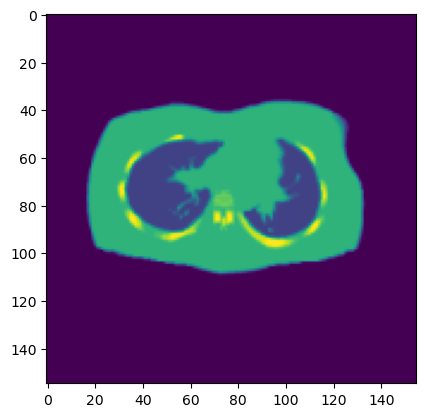

In [17]:
%matplotlib inline
plt.imshow(numpy.squeeze(attn_image.as_array()))

In [18]:
# create attenuation
acq_model_for_attn = STIR.AcquisitionModelUsingRayTracingMatrix()
asm_attn = STIR.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
asm_attn = STIR.AcquisitionSensitivityModel(attn_factors)
# set it up
asm_attn.set_up(template)
# use "standard" terminology for multiplicative factor (Note: there is no norm here)
mult_factors = attn_factors
# fake background (randoms+scatter)
background = template.get_uniform_copy(1)
# find additive_term for the acq_model
additive_term = background.clone()
asm_attn.normalise(additive_term)

# create acquisition model
acq_model = STIR.AcquisitionModelUsingRayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for this demo of course)
acq_model.set_num_tangential_LORs(5)
acq_model.set_acquisition_sensitivity(asm_attn)
acq_model.set_additive_term(additive_term)
# set-up
acq_model.set_up(template,image)

#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)

print(acquired_data.max())

9.694265


### run initial OSEM

In [19]:
#%% save max and central slice for future displays
cmax = image.max()*.6
im_slice = image.dimensions()[0] // 2

In [20]:
initial_image = image.get_uniform_copy()

In [21]:
acq_model, obj_fun = create_acq_model_and_obj_fun(acquired_data, additive_term, mult_factors, initial_image)

In [22]:
initial_image = scale_initial_image(acquired_data, additive_term, mult_factors, initial_image, obj_fun)
OSEM_image = OSEM(obj_fun, initial_image, num_updates=30)

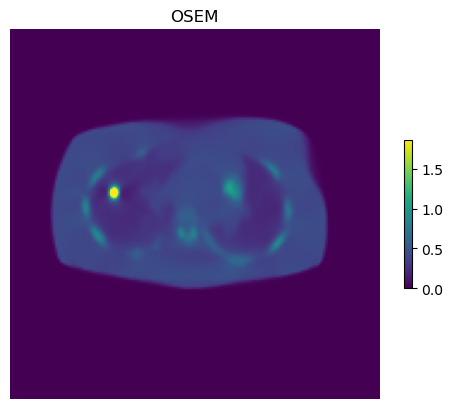

In [23]:
plt.figure()
plot_2d_image([1,1,1], OSEM_image.as_array()[im_slice,:,:], 'OSEM',[0,cmax])

### Construct the prior

We will use a smoothed RDP with voxel-dependent weights (see function definitions above)

In [24]:
kappa = compute_kappa_image(obj_fun, OSEM_image)

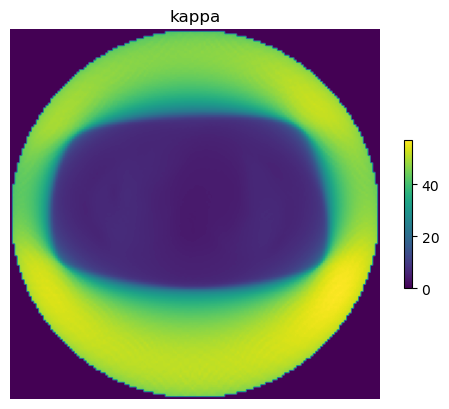

In [25]:
plt.figure()
plot_2d_image([1,1,1], kappa.as_array()[im_slice,:,:], 'kappa')

In [26]:
prior = construct_RDP(1/36, OSEM_image, kappa)

### partition data (i.e. construct subsets) and adjust prior accordingly

Use `partitioner.data_partition` to get a list of subset data, as well as corresponding acquisition models and objective functions. We'll add the prior evenly to each objective function.

In [27]:
num_subsets = 7
data,acq_models, obj_funs = partitioner.data_partition(acquired_data,additive_term,mult_factors, num_subsets)

add_prior_to_obj_funs(obj_funs, prior)

Remember that this modified the penalty strength of the `prior` object.

In [28]:
prior.get_penalisation_factor()

0.02777777798473835

### compare 2 BSREM implementations

`BSREM1` etc are derived from `cil.Algorithm`, Check its help message for more information.

Some notes on terminology:
- CIL uses `loss` for the objective function value. This is somewhat confusing here, as we are maximising the objective function...
- `cil.Algorithm` uses `iteration` for every call to `update`. This might not be what you expect for a subset algorithm.

Note: intentionally setting update_objective_intervals to be not a multiple of num_subsets such that we can see the oscillations

In [29]:
max_iteration = 300

In [30]:
bsrem1 = BSREM1(data, obj_funs, initial=OSEM_image, initial_step_size=1, relaxation_eta=.05, update_objective_interval=5)
bsrem1.run(iterations=max_iteration)

  0%|          | 0/300 [00:00<?, ?it/s]

In [31]:
bsrem2=BSREM2(data, acq_models, prior, initial=OSEM_image, initial_step_size=1, relaxation_eta=.05, update_objective_interval=5)
bsrem2.run(iterations=max_iteration)

  0%|          | 0/300 [00:00<?, ?it/s]

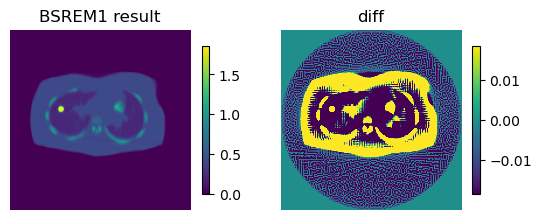

In [32]:
plt.figure()
tmp1=bsrem1.x
tmp2=bsrem2.x
plot_2d_image([1,2,1], tmp1.as_array()[im_slice,:,:], 'BSREM1 result',[0, cmax])
plot_2d_image([1,2,2], (tmp1-tmp2).as_array()[im_slice,:,:], 'diff',[-cmax/100, cmax/100])

Plot objective function for both implementations. If all well, you should see only 1 curve

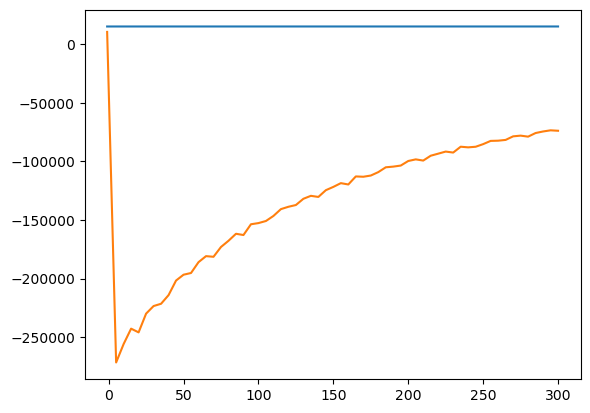

In [33]:
plt.figure()
plt.plot(bsrem1.iterations, bsrem1.loss)
plt.plot(bsrem2.iterations, bsrem2.loss);


In [ ]:
plt.close('all')

## Now use the NEMA IQ data acquired on the mMR

The following names assume the data for the acquisition model has been written already by a preprocessing script. You might need to adjust this to your location and set-up.

In [ ]:
os.chdir('/home/kris/data/mMR/NEMA_IQ/tmpl')

In [ ]:
acquired_data = STIR.AcquisitionData('prompts.hs')
additive_term = STIR.AcquisitionData('additive_term.hs')
mult_factors = STIR.AcquisitionData('mult_factors.hs')

In [ ]:
# Let's use the attenuation image to get descent voxel-sizes etc
# you might get a lot of warnings on "unrecognized keyword". Just ignore these...
initial_image = STIR.ImageData('20170809_NEMA_MUMAP_UCL.hv')
# crop it a bit to avoid wasting time
initial_image=initial_image.zoom_image(zooms=(1,1,1), offsets_in_mm=(0,0,0), size=(-1,200,200))

In [ ]:
# run OSEM (see previous example) and construct kappa etc
acq_model, obj_fun = create_acq_model_and_obj_fun(acquired_data, additive_term, mult_factors, initial_image)

initial_image = scale_initial_image(acquired_data, additive_term, mult_factors, initial_image, obj_fun)
OSEM_image = OSEM(obj_fun, initial_image, num_updates=14)

kappa = compute_kappa_image(obj_fun, OSEM_image)

In [ ]:
# set to reasonable values for display
cmax = OSEM_image.max()*1.1
im_slice = 70 # for this acquisition, this might give a slcie through the spheres

In [ ]:
plt.figure()
plot_2d_image([1,1,1], OSEM_image.as_array()[im_slice,:,:], 'OSEM',[0, OSEM_image.max()])

In [ ]:
plt.figure()
plot_2d_image([1,1,1], kappa.as_array()[im_slice,:,:], 'kappa')

In [ ]:
prior = construct_RDP(1/700, OSEM_image, kappa)

In [ ]:
plt.figure()
plot_2d_image([1,2,1], OSEM_image.as_array()[:,:,OSEM_image.dimensions()[1]//2 - 5], 'OSEM sagittal',[0,cmax])
plot_2d_image([1,2,2], OSEM_image.as_array()[im_slice,:,:], 'OSEM transverse',[0,cmax])

In [ ]:
num_subsets = 7
data,acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets)

In [ ]:
add_prior_to_obj_funs(obj_funs, prior)

In [ ]:
bsrem1 = BSREM1(data, obj_funs, initial=OSEM_image, initial_step_size=.3, relaxation_eta=.05, update_objective_interval=10)
bsrem1.run(iterations=80)

In [ ]:
print(bsrem1.x.max())
plt.figure()
plot_2d_image([1,2,2], bsrem1.x.as_array()[im_slice,:,:], 'BSREM',[0, bsrem1.x.max()])

In [ ]:
plt.figure()
plot_2d_image([1,2,1], OSEM_image.as_array()[im_slice,:,:], 'initial OSEM',[0, cmax])
plot_2d_image([1,2,2], bsrem1.x.as_array()[im_slice,:,:], 'BSREM',[0, cmax])

In [ ]:
plt.figure()
plt.plot(bsrem1.iterations, bsrem1.loss);

In [ ]:
plt.close('all')